# 1. Introduction

# 2. Data

The data comes from [Kaggle](https://www.kaggle.com/mlg-ulb/creditcardfraud) and contains ~285k credit card transactions and 31 variables.

There are no missing values.

Data dictionary

It contains only numerical input variables which are the result of a PCA transformation. Unfortunately, due to confidentiality issues, we cannot provide the original features and more background information about the data. Features V1, V2, … V28 are the principal components obtained with PCA, the only features which have not been transformed with PCA are 'Time' and 'Amount'. Feature 'Time' contains the seconds elapsed between each transaction and the first transaction in the dataset. The feature 'Amount' is the transaction Amount, this feature can be used for example-dependant cost-senstive learning. Feature 'Class' is the response variable and it takes value 1 in case of fraud and 0 otherwise.

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import RandomForestClassifier

from keras.layers import Input, Dense, Dropout
from keras.models import Model, Sequential
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score
from sklearn import preprocessing
from sklearn.model_selection import train_test_split

from keras import regularizers

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/creditcardfraud/creditcard.csv


In [2]:
raw = pd.read_csv('/kaggle/input/creditcardfraud/creditcard.csv')
raw.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [3]:
raw.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,...,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,94813.859575,3.919560e-15,5.688174e-16,-8.769071e-15,2.782312e-15,-1.552563e-15,2.010663e-15,-1.694249e-15,-1.927028e-16,-3.137024e-15,...,1.537294e-16,7.959909e-16,5.367590e-16,4.458112e-15,1.453003e-15,1.699104e-15,-3.660161e-16,-1.206049e-16,88.349619,0.001727
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,...,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,...,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,...,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,...,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,...,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,...,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


In [4]:
raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

In [5]:
# Check for missing values
print(raw.isna().sum() )
print('\n====total missing values:', raw.isna().sum().sum() )

Time      0
V1        0
V2        0
V3        0
V4        0
V5        0
V6        0
V7        0
V8        0
V9        0
V10       0
V11       0
V12       0
V13       0
V14       0
V15       0
V16       0
V17       0
V18       0
V19       0
V20       0
V21       0
V22       0
V23       0
V24       0
V25       0
V26       0
V27       0
V28       0
Amount    0
Class     0
dtype: int64

====total missing values: 0


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:4: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  after removing the cwd from sys.path.


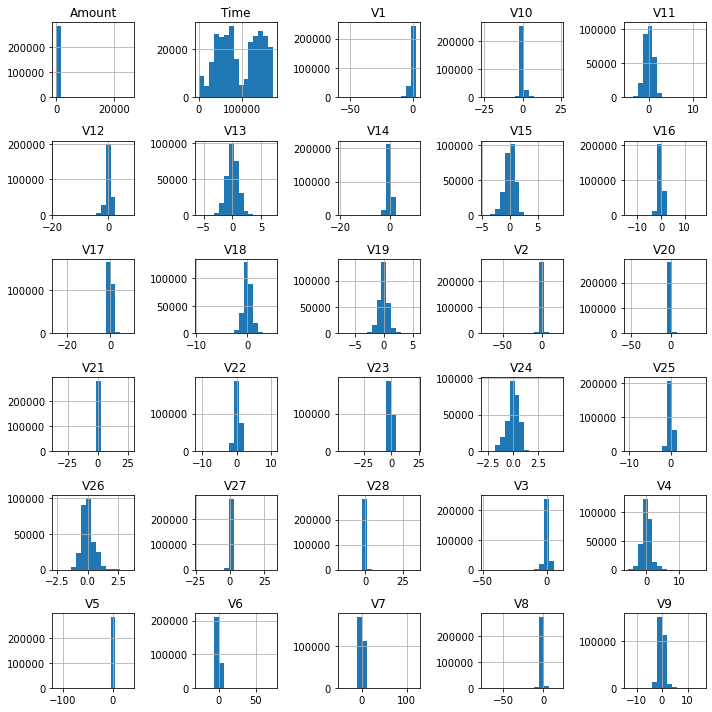

In [6]:
# Histograms of all features
fig = plt.figure(figsize = (10,10))
ax = fig.gca()
raw.drop(['Class'],axis=1).hist(ax=ax, bins=15)
plt.tight_layout()

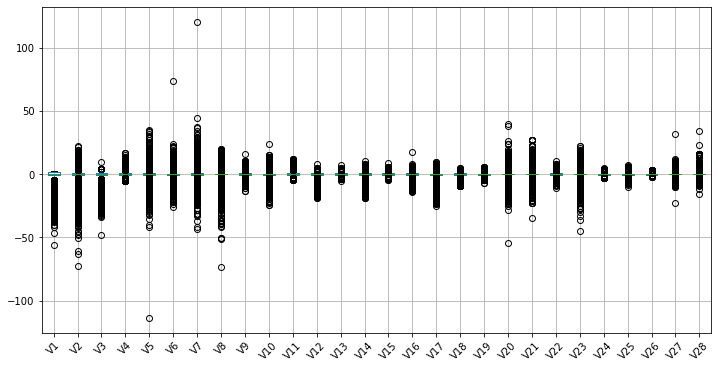

In [7]:
# Boxplots
raw.drop(['Time','Amount','Class'], axis=1).boxplot(figsize=(12,6), rot=45)

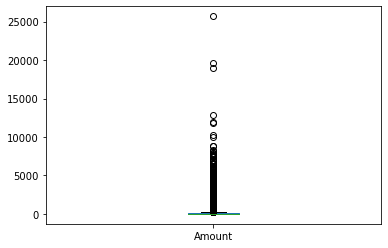

In [8]:
raw['Amount'].plot.box()

In [9]:
# check correlations
raw.corr()['Class']

Time     -0.012323
V1       -0.101347
V2        0.091289
V3       -0.192961
V4        0.133447
V5       -0.094974
V6       -0.043643
V7       -0.187257
V8        0.019875
V9       -0.097733
V10      -0.216883
V11       0.154876
V12      -0.260593
V13      -0.004570
V14      -0.302544
V15      -0.004223
V16      -0.196539
V17      -0.326481
V18      -0.111485
V19       0.034783
V20       0.020090
V21       0.040413
V22       0.000805
V23      -0.002685
V24      -0.007221
V25       0.003308
V26       0.004455
V27       0.017580
V28       0.009536
Amount    0.005632
Class     1.000000
Name: Class, dtype: float64

From the visual, there's some correlation between payments vs purchases and transactions vs frequency. But nothing obvious to cluster groups.

In [10]:
anomalies = raw['Class'].value_counts().to_frame().reset_index()
anomalies['percent'] = anomalies["Class"].apply(lambda x : round(100*float(x) / raw.shape[0], 2))
anomalies.rename(columns = {"index" : "Target", "Class" : "Count"})

,Target,Count,percent
0,0,284315,99.83
1,1,492,0.17


~0.17% anomalies

In [11]:
# Determine how much time is in the dataset
maxTime = raw['Time'].max()
maxTimeMinutes = maxTime/60
maxTimeHours = maxTimeMinutes/60
maxTimeDays = maxTimeHours/24
print('minutes:', round(maxTimeMinutes,0), 
      ', hours:', round(maxTimeHours,0),
      ', days:', round(maxTimeDays,2) )

minutes: 2880.0 , hours: 48.0 , days: 2.0


2 days worth of data is in the dataset

# 3. Pre-processing

## a. New Features

In [3]:
# Create new feature for time that is by hour
raw['byHour'] = (raw['Time']/(60*60) ) % 24
raw.drop(['Time'], axis=1)

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V22,V23,V24,V25,V26,V27,V28,Amount,Class,byHour
0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,...,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0,0.000000
1,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,...,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0,0.000000
2,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,...,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0,0.000278
3,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,...,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0,0.000278
4,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,...,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0,0.000556
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
284802,-11.881118,10.071785,-9.834783,-2.066656,-5.364473,-2.606837,-4.918215,7.305334,1.914428,4.356170,...,0.111864,1.014480,-0.509348,1.436807,0.250034,0.943651,0.823731,0.77,0,23.996111
284803,-0.732789,-0.055080,2.035030,-0.738589,0.868229,1.058415,0.024330,0.294869,0.584800,-0.975926,...,0.924384,0.012463,-1.016226,-0.606624,-0.395255,0.068472,-0.053527,24.79,0,23.996389
284804,1.919565,-0.301254,-3.249640,-0.557828,2.630515,3.031260,-0.296827,0.708417,0.432454,-0.484782,...,0.578229,-0.037501,0.640134,0.265745,-0.087371,0.004455,-0.026561,67.88,0,23.996667
284805,-0.240440,0.530483,0.702510,0.689799,-0.377961,0.623708,-0.686180,0.679145,0.392087,-0.399126,...,0.800049,-0.163298,0.123205,-0.569159,0.546668,0.108821,0.104533,10.00,0,23.996667


## b. Split the dataset

In [31]:
Xraw = raw.drop(['Class'], axis=1)
yraw = raw['Class']

In [32]:
# Standardize

from sklearn.preprocessing import StandardScaler
Xstd = StandardScaler().fit_transform(Xraw)
Xstd = pd.DataFrame(Xstd)

In [33]:
#split the dataset
X_train, X_test, y_train, y_test = train_test_split(
    Xstd, yraw, test_size=0.2, random_state=123, stratify=yraw)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  """


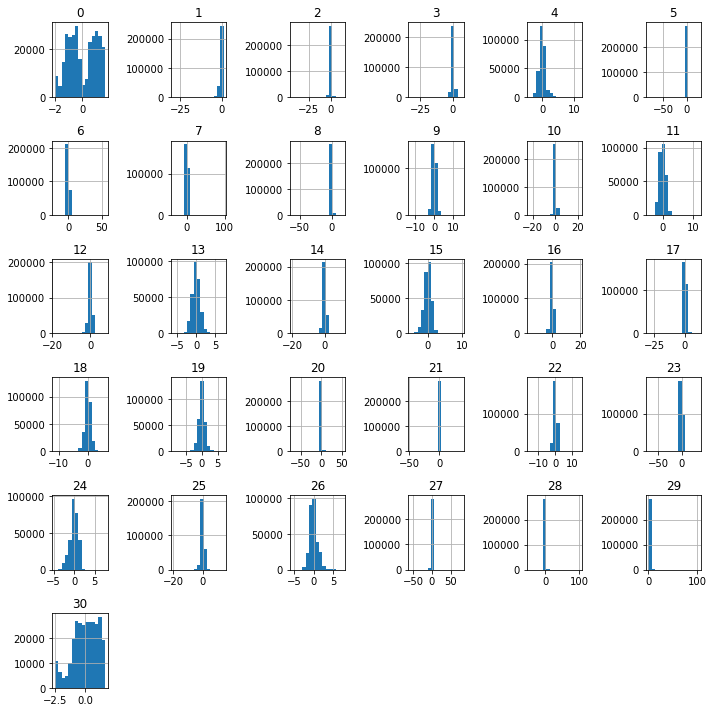

In [16]:
# show standardized histograms
# Histograms of all features
fig = plt.figure(figsize = (10,10))
ax = fig.gca()
Xstd.hist(ax=ax, bins=15)
plt.tight_layout()

## c. Visualize fraud/non-fraud

In [17]:
non_fraud_1k = raw[raw['Class'] == 0].sample(1000)
fraud = raw[raw['Class'] == 1]

df = non_fraud_1k.append(fraud).sample(frac=1).reset_index(drop=True)
X = df.drop(['Class'], axis = 1).values
Y = df["Class"].values

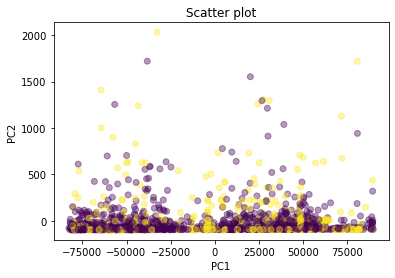

In [18]:
from sklearn.decomposition import PCA
pca = PCA(2)
x_pca = pca.fit_transform(X)
x_pca = pd.DataFrame(x_pca)
x_pca.columns=['PC1','PC2']

# Plot
plt.scatter(x_pca.PC1, x_pca.PC2, c=Y, alpha=0.4)
plt.title('Scatter plot')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.show()

yellow circles are the anomalies, and as shown in the scatter plot above they're difficult to visualize with PCA.

In [19]:
from sklearn.manifold import TSNE

def tsne_plot(x1, y1, name="graph.png"):
    tsne = TSNE(n_components=2, random_state=0)
    X_t = tsne.fit_transform(x1)

    plt.figure(figsize=(12, 8))
    plt.scatter(X_t[np.where(y1 == 0), 0], X_t[np.where(y1 == 0), 1], marker='o', color='g', linewidth='1', alpha=0.8, label='Non Fraud')
    plt.scatter(X_t[np.where(y1 == 1), 0], X_t[np.where(y1 == 1), 1], marker='o', color='r', linewidth='1', alpha=0.8, label='Fraud')

    plt.legend(loc='best');
    plt.savefig(name);
    plt.show();

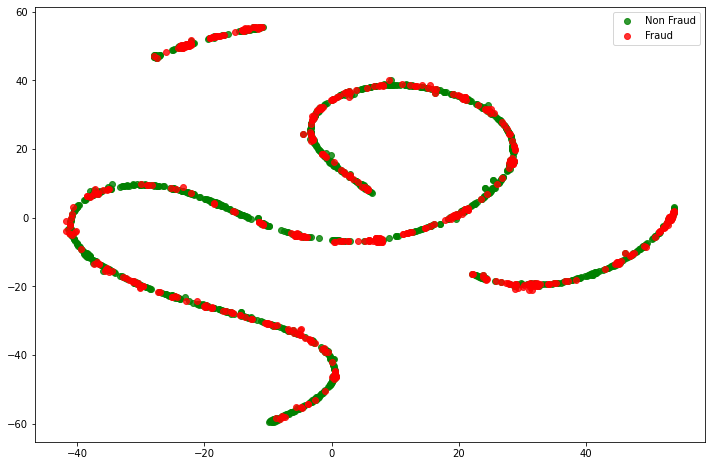

In [20]:
tsne_plot(X, Y, "original.png")

Even with tSNE, still can't separate fraud and non-fraud datapoints

## d. Utility functions

In [34]:
# Utility functions
def scores(y, y_pred):
#    print('F1 score', f1_score(y, y_pred) )
#    print('Recall', recall_score(y, y_pred) )
#    print( 'Precision:', precision_score(y, y_pred) )
    print('\n clasification report:\n', classification_report(y, y_pred) )

In [35]:
# drops score_time and
# adds the mean and stdev as rows of a dataframe
def add_stats_to_df(df):
    m = pd.Series(df.mean(), name='mean')
    s = pd.Series(df.std(), name='stdev')
    return df.append(m, ignore_index=False).append(s, ignore_index=False).drop(['score_time'], axis=1)

## e. Setup for cross-validation

In [36]:
# for cross-validation, want to record the scores below
scoring=['roc_auc','f1','precision','recall']

In [37]:
from sklearn.model_selection import StratifiedKFold  # should this be repeatedStratified?
from sklearn.model_selection import cross_val_score, cross_validate

skf = StratifiedKFold(n_splits=5)

In [38]:
X = X_train
y = y_train

# 4. Methods

## a. Random Forest

In [39]:
rfc_a = RandomForestClassifier()

#scores = cross_val_score(rfc, X, y, scoring='roc_auc', cv=skf, n_jobs=-1)
scores_a = cross_validate(rfc_a, X, y, scoring=scoring, cv=skf, n_jobs=-1)
pd_scores_a = add_stats_to_df(pd.DataFrame(scores_a) )
pd_scores_a

,fit_time,test_roc_auc,test_f1,test_precision,test_recall
0,282.115462,0.947286,0.899329,0.943662,0.858974
1,284.285153,0.967150,0.864865,0.927536,0.810127
2,286.469775,0.954271,0.867133,0.968750,0.784810
3,278.822222,0.960231,0.847222,0.938462,0.772152
4,197.483777,0.921841,0.840580,0.983051,0.734177
mean,265.835278,0.950156,0.863826,0.952292,0.792048
stdev,38.313879,0.017444,0.022850,0.022889,0.046377


Hyper-parmeters tuned: n_estimators, max_depth, max_features, criterion

In [40]:
rfc_b = RandomForestClassifier(n_estimators=70, 
                            max_depth=7, max_features=7, criterion='entropy')

scores_b = cross_validate(rfc_b, X, y, scoring=scoring, cv=skf, n_jobs=-1)
pd_scores_b = add_stats_to_df(pd.DataFrame(scores_b) )
pd_scores_b

,fit_time,test_roc_auc,test_f1,test_precision,test_recall
0,169.130756,0.983151,0.893333,0.930556,0.858974
1,174.144798,0.981244,0.868966,0.954545,0.797468
2,172.694003,0.973975,0.873239,0.984127,0.784810
3,173.599998,0.992810,0.841379,0.924242,0.772152
4,117.101907,0.976626,0.848921,0.983333,0.746835
mean,161.334292,0.981561,0.865168,0.955361,0.792048
stdev,24.803671,0.007264,0.020632,0.028259,0.041836


Modify weights to penalize errors of the positive class more than errors of the negative class

In [28]:
rfc_c = RandomForestClassifier(n_estimators=70, class_weight='balanced_subsample',
                            max_depth=7, max_features=7, criterion='entropy')

scores_c = cross_validate(rfc_c, X, y, scoring=scoring, cv=skf, n_jobs=-1)
pd_scores_c = add_stats_to_df(pd.DataFrame(scores_c) )
pd_scores_c

,fit_time,test_roc_auc,test_f1,test_precision,test_recall
0,171.970078,0.983849,0.850000,0.829268,0.871795
1,174.261923,0.989982,0.835443,0.835443,0.835443
2,168.216305,0.970012,0.790123,0.771084,0.810127
3,171.432262,0.995728,0.858974,0.870130,0.848101
4,124.677017,0.972437,0.832215,0.885714,0.784810
mean,162.111517,0.982402,0.833351,0.838328,0.830055
stdev,21.037527,0.011067,0.026495,0.044353,0.033694


Vary hyper-parameters

In [29]:
rfc_d = RandomForestClassifier(n_estimators=50, class_weight='balanced_subsample',
                            max_depth=5, max_features=7, criterion='entropy')

scores_d = cross_validate(rfc_d, X, y, scoring=scoring, cv=skf, n_jobs=-1)
pd_scores_d = add_stats_to_df(pd.DataFrame(scores_d) )
pd_scores_d

,fit_time,test_roc_auc,test_f1,test_precision,test_recall
0,102.390851,0.978555,0.657143,0.522727,0.884615
1,103.237407,0.983225,0.651163,0.514706,0.886076
2,99.177653,0.975104,0.650246,0.532258,0.835443
3,105.326253,0.994791,0.744444,0.663366,0.848101
4,74.029622,0.974714,0.696629,0.626263,0.784810
mean,96.832357,0.981278,0.679925,0.571864,0.847809
stdev,12.937667,0.008292,0.040832,0.068158,0.041656


In [30]:
rfc_e = RandomForestClassifier(n_estimators=50, class_weight='balanced_subsample',
                            max_depth=5, max_features=5, criterion='entropy')

scores_e = cross_validate(rfc_e, X, y, scoring=scoring, cv=skf, n_jobs=-1)
pd_scores_e = add_stats_to_df(pd.DataFrame(scores_e) )
pd_scores_e

,fit_time,test_roc_auc,test_f1,test_precision,test_recall
0,79.953079,0.984435,0.718750,0.605263,0.884615
1,77.249455,0.985111,0.723404,0.623853,0.860759
2,80.705823,0.972226,0.673267,0.552846,0.860759
3,76.177250,0.993921,0.731183,0.635514,0.860759
4,55.408457,0.981384,0.696133,0.617647,0.797468
mean,73.898813,0.983415,0.708547,0.607025,0.852872
stdev,10.503581,0.007804,0.023643,0.032195,0.032649


In [31]:
rfc_f = RandomForestClassifier(n_estimators=100, class_weight='balanced_subsample',
                            max_depth=10, max_features=10, criterion='entropy')

scores_f = cross_validate(rfc_f, X, y, scoring=scoring, cv=skf, n_jobs=-1)
pd_scores_f = add_stats_to_df(pd.DataFrame(scores_f) )
pd_scores_f

,fit_time,test_roc_auc,test_f1,test_precision,test_recall
0,344.222924,0.963979,0.874172,0.904110,0.846154
1,340.821362,0.974616,0.863014,0.940299,0.797468
2,346.665406,0.981666,0.868966,0.954545,0.797468
3,342.339724,0.994258,0.872483,0.928571,0.822785
4,229.223715,0.957758,0.830986,0.936508,0.746835
mean,320.654626,0.974455,0.861924,0.932807,0.802142
stdev,51.158033,0.014428,0.017815,0.018600,0.036965


## b. SMOTE

technique adapted from
https://machinelearningmastery.com/smote-oversampling-for-imbalanced-classification/

In [45]:
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline
from imblearn.under_sampling import RandomUnderSampler

### i. Base

In [33]:
# define pipeline
steps = [('over', SMOTE()), ('model', RandomForestClassifier())]
pipeline = Pipeline(steps=steps)
# evaluate pipeline
scores_A = cross_validate(pipeline, X, y, scoring=scoring, cv=skf, n_jobs=-1)
pd_scores_A = add_stats_to_df(pd.DataFrame(scores_A) )
pd_scores_A

,fit_time,test_roc_auc,test_f1,test_precision,test_recall
0,518.443680,0.969555,0.866242,0.860759,0.871795
1,507.090591,0.976886,0.880000,0.929577,0.835443
2,514.419026,0.955346,0.847682,0.888889,0.810127
3,486.480585,0.974932,0.845638,0.900000,0.797468
4,391.737502,0.972614,0.849315,0.925373,0.784810
mean,483.634277,0.969866,0.857775,0.900920,0.819929
stdev,52.826870,0.008565,0.014886,0.028185,0.034513


### ii. Add random undersample

In [34]:
# Oversample with SMOTE and random undersample for imbalanced dataset

rfc_smote = RandomForestClassifier()
over = SMOTE(sampling_strategy=0.1)
under = RandomUnderSampler(sampling_strategy=0.5)
steps = [('over', over), ('under', under), ('model', rfc_smote)]
pipeline = Pipeline(steps=steps)
# evaluate pipeline
scores_B = cross_validate(pipeline, X, y, scoring=scoring, cv=skf, n_jobs=-1)
pd_scores_B = add_stats_to_df(pd.DataFrame(scores_B) )
pd_scores_B

,fit_time,test_roc_auc,test_f1,test_precision,test_recall
0,43.608073,0.978564,0.816568,0.758242,0.884615
1,44.242041,0.984827,0.819277,0.781609,0.860759
2,44.800789,0.975838,0.800000,0.747253,0.860759
3,42.619473,0.989014,0.844720,0.829268,0.860759
4,30.618941,0.980202,0.777778,0.759036,0.797468
mean,41.177863,0.981689,0.811669,0.775082,0.852872
stdev,5.957973,0.005237,0.024794,0.032765,0.032649


### iii. Check for different k-values

In [35]:

k_values = [1, 2, 3, 4, 5, 6, 7]
for k in k_values:
    # define pipeline
    model = RandomForestClassifier()
    over = SMOTE(sampling_strategy=0.1, k_neighbors=k)
    under = RandomUnderSampler(sampling_strategy=0.5)
    steps = [('over', over), ('under', under), ('model', model)]
    pipeline = Pipeline(steps=steps)
    # evaluate pipeline
    scores = cross_validate(pipeline, X, y, scoring=scoring, cv=skf, n_jobs=-1)
    print('k: ',k)
    pd_scores = add_stats_to_df(pd.DataFrame(scores) )
    print(pd_scores)

k:  1
        fit_time  test_roc_auc   test_f1  test_precision  test_recall
0      41.238777      0.978552  0.867925        0.851852     0.884615
1      40.883088      0.973411  0.848101        0.848101     0.848101
2      40.572469      0.957910  0.795031        0.780488     0.810127
3      40.830853      0.994119  0.855346        0.850000     0.860759
4      27.422102      0.963643  0.823529        0.851351     0.797468
mean   38.189458      0.973527  0.837986        0.836358     0.840214
stdev   6.023820      0.014061  0.028957        0.031266     0.036015
k:  2
        fit_time  test_roc_auc   test_f1  test_precision  test_recall
0      50.302538      0.985330  0.846626        0.811765     0.884615
1      51.655964      0.980142  0.844720        0.829268     0.860759
2      47.597545      0.961470  0.840764        0.846154     0.835443
3      49.487308      0.985697  0.819277        0.781609     0.860759
4      29.252380      0.954418  0.843537        0.911765     0.784810
mean   4

## c. Autoencoder 

## Transfer from previous Kaggle notebook

from
https://www.kaggle.com/shivamb/semi-supervised-classification-using-autoencoders


Modifications from above model include using l1_l2 regularization and adding dropout layer

In [13]:
np.random.seed(203)

In [13]:
non_fraud = raw[raw['Class'] == 0].sample(2000)
fraud = raw[raw['Class'] == 1]

df = non_fraud.append(fraud).sample(frac=1).reset_index(drop=True)
X = df.drop(['Class'], axis = 1).values
Y = df["Class"].values

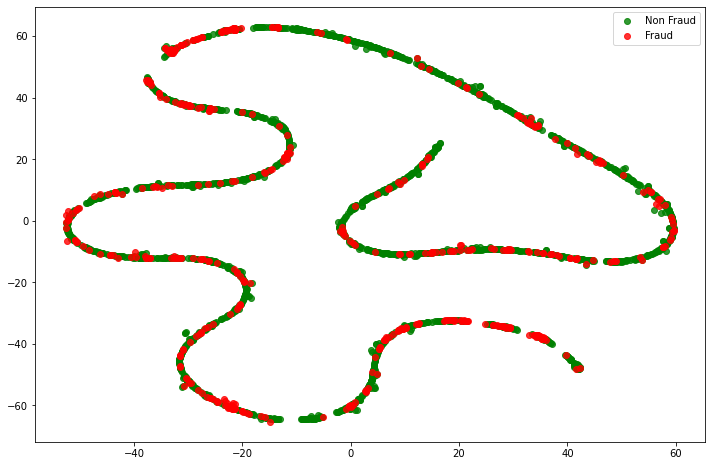

In [18]:
from sklearn.manifold import TSNE
def tsne_plot(x1, y1, name="graph.png"):
    tsne = TSNE(n_components=2, random_state=0)
    X_t = tsne.fit_transform(x1)

    plt.figure(figsize=(12, 8))
    plt.scatter(X_t[np.where(y1 == 0), 0], X_t[np.where(y1 == 0), 1], marker='o', color='g', linewidth='1', alpha=0.8, label='Non Fraud')
    plt.scatter(X_t[np.where(y1 == 1), 0], X_t[np.where(y1 == 1), 1], marker='o', color='r', linewidth='1', alpha=0.8, label='Fraud')

    plt.legend(loc='best');
    plt.savefig(name);
    plt.show();
    
tsne_plot(X, Y, "original.png")

In [14]:
# MinMax scaler only
from sklearn.preprocessing import MinMaxScaler
x_scale = MinMaxScaler().fit_transform(Xraw)
x_norm, x_fraud = x_scale[yraw == 0], x_scale[yraw == 1]
Xminmax = pd.DataFrame(x_scale)

In [15]:
# use 2.5% of the dataset for training
X_train, _, y_train, _ = train_test_split(
    Xminmax, yraw, test_size=.975, random_state=123, stratify=yraw)

In [16]:
x_norm_enc = X_train[y_train == 0]
x_norm_enc.shape

(7108, 31)

### i. Base Model

In [47]:
## input layer 
input_layer = Input(shape=(X.shape[1],))

## encoding part
encoded = Dense(100, activation='tanh', activity_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4))(input_layer)
encoded = Dropout(0.2)(encoded)
encoded = Dense(50, activation='relu',activity_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4))(encoded)
encoded = Dropout(0.1)(encoded)

## decoding part
decoded = Dense(50, activation='tanh')(encoded)
decoded = Dense(100, activation='tanh')(decoded)

## output layer
output_layer = Dense(X.shape[1], activation='relu')(decoded)

In [48]:
autoencoder = Model(input_layer, output_layer)
autoencoder.compile(optimizer="adadelta", loss="mse")

In [49]:
autoencoder.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 31)]              0         
_________________________________________________________________
dense_14 (Dense)             (None, 100)               3200      
_________________________________________________________________
dropout_4 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_15 (Dense)             (None, 50)                5050      
_________________________________________________________________
dropout_5 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_16 (Dense)             (None, 50)                2550      
_________________________________________________________________
dense_17 (Dense)             (None, 100)               5100

In [50]:
autoencoder.fit(x_norm_enc, x_norm_enc, 
                epochs = 100,   
                shuffle = True, validation_split = 0.20);

Epoch 1/100
178/178 [==============================] - 1s 3ms/step - loss: 0.2304 - val_loss: 0.2236
Epoch 2/100
178/178 [==============================] - 0s 2ms/step - loss: 0.2249 - val_loss: 0.2165
Epoch 3/100
178/178 [==============================] - 0s 2ms/step - loss: 0.2190 - val_loss: 0.2095
Epoch 4/100
178/178 [==============================] - 0s 2ms/step - loss: 0.2126 - val_loss: 0.2025
Epoch 5/100
178/178 [==============================] - 0s 2ms/step - loss: 0.2069 - val_loss: 0.1954
Epoch 6/100
178/178 [==============================] - 0s 2ms/step - loss: 0.2008 - val_loss: 0.1888
Epoch 7/100
178/178 [==============================] - 0s 2ms/step - loss: 0.1953 - val_loss: 0.1823
Epoch 8/100
178/178 [==============================] - 0s 2ms/step - loss: 0.1895 - val_loss: 0.1751
Epoch 9/100
178/178 [==============================] - 0s 2ms/step - loss: 0.1834 - val_loss: 0.1681
Epoch 10/100
178/178 [==============================] - 0s 2ms/step - loss: 0.1771 - val_lo

178/178 [==============================] - 0s 2ms/step - loss: 0.0915 - val_loss: 0.0823
Epoch 82/100
178/178 [==============================] - 0s 2ms/step - loss: 0.0911 - val_loss: 0.0823
Epoch 83/100
178/178 [==============================] - 0s 2ms/step - loss: 0.0913 - val_loss: 0.0823
Epoch 84/100
178/178 [==============================] - 0s 2ms/step - loss: 0.0910 - val_loss: 0.0823
Epoch 85/100
178/178 [==============================] - 0s 3ms/step - loss: 0.0911 - val_loss: 0.0823
Epoch 86/100
178/178 [==============================] - 0s 2ms/step - loss: 0.0910 - val_loss: 0.0823
Epoch 87/100
178/178 [==============================] - 0s 2ms/step - loss: 0.0912 - val_loss: 0.0823
Epoch 88/100
178/178 [==============================] - 0s 2ms/step - loss: 0.0909 - val_loss: 0.0823
Epoch 89/100
178/178 [==============================] - 0s 2ms/step - loss: 0.0908 - val_loss: 0.0822
Epoch 90/100
178/178 [==============================] - 0s 2ms/step - loss: 0.0907 - val_loss: 

In [51]:
hidden_representation = Sequential()
hidden_representation.add(autoencoder.layers[0])
hidden_representation.add(autoencoder.layers[1])
hidden_representation.add(autoencoder.layers[2])

hidden_representation.add(autoencoder.layers[3])
hidden_representation.add(autoencoder.layers[4])

In [52]:
hidden_representation.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_14 (Dense)             (None, 100)               3200      
_________________________________________________________________
dropout_4 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_15 (Dense)             (None, 50)                5050      
_________________________________________________________________
dropout_5 (Dropout)          (None, 50)                0         
Total params: 8,250
Trainable params: 8,250
Non-trainable params: 0
_________________________________________________________________


In [53]:
# will use only 3k of the normal data to compare against model from link
norm_hid_rep = hidden_representation.predict(x_norm[:3000])
fraud_hid_rep = hidden_representation.predict(x_fraud)

In [54]:
rep_x = np.append(norm_hid_rep, fraud_hid_rep, axis = 0)
y_n = np.zeros(norm_hid_rep.shape[0])
y_f = np.ones(fraud_hid_rep.shape[0])
rep_y = np.append(y_n, y_f)

In [30]:
enc_train_x, val_x, enc_train_y, val_y = train_test_split(rep_x, rep_y,
                                random_state=123, test_size=0.5, stratify=rep_y)


rfc_enc = RandomForestClassifier(random_state=123)
rfc_enc.fit(enc_train_x, enc_train_y)
ypred_train = rfc_enc.predict(enc_train_x)
ypred_test = rfc_enc.predict(val_x)

print('Random forest training')
print('test set')
scores(val_y, ypred_test)

Random forest training
test set

 clasification report:
               precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      1500
         1.0       1.00      0.98      0.99       246

    accuracy                           1.00      1746
   macro avg       1.00      0.99      1.00      1746
weighted avg       1.00      1.00      1.00      1746



Scores compare favorably to those from the link

Will proceed with using cross-validation on full dataset

In [25]:
norm_hid_rep = hidden_representation.predict(x_norm)
fraud_hid_rep = hidden_representation.predict(x_fraud)

rep_x = np.append(norm_hid_rep, fraud_hid_rep, axis = 0)
y_n = np.zeros(norm_hid_rep.shape[0])
y_f = np.ones(fraud_hid_rep.shape[0])
rep_y = np.append(y_n, y_f)

In [26]:
# Verify shape
rep_x.shape

(284807, 50)

In [27]:
# split the hidden representation dataset
X_train_enc, X_test_enc, y_train_enc, y_test_enc = train_test_split(
    rep_x, rep_y, test_size=0.2, random_state=123, stratify=rep_y)

In [36]:
rfc_enc_a = RandomForestClassifier(random_state=123)

scores_enc_a = cross_validate(rfc_enc_a, X_train_enc, y_train_enc, 
                              scoring=scoring, cv=skf, n_jobs=-1)
pd_scores_enc_a = add_stats_to_df(pd.DataFrame(scores_enc_a) )
pd_scores_enc_a

,fit_time,test_roc_auc,test_f1,test_precision,test_recall
0,198.901194,0.946718,0.778626,0.962264,0.653846
1,196.091691,0.940804,0.748092,0.942308,0.620253
2,204.098608,0.934216,0.787879,0.981132,0.658228
3,198.495772,0.953189,0.769231,0.980392,0.632911
4,134.595629,0.914665,0.787879,0.981132,0.658228
mean,186.436579,0.937918,0.774341,0.969446,0.644693
stdev,29.126634,0.014777,0.016583,0.017183,0.017221


Try different hyperparameters

In [37]:
rfc_enc_b = RandomForestClassifier(n_estimators=70, class_weight='balanced_subsample',
                            max_depth=7, max_features=7, criterion='entropy')

scores_enc_b = cross_validate(rfc_enc_b, X_train_enc, y_train_enc, scoring=scoring, cv=skf, n_jobs=-1)
pd_scores_enc_b = add_stats_to_df(pd.DataFrame(scores_enc_b) )
pd_scores_enc_b

,fit_time,test_roc_auc,test_f1,test_precision,test_recall
0,77.533378,0.965356,0.707182,0.621359,0.820513
1,76.083398,0.963105,0.756098,0.729412,0.784810
2,76.022728,0.959026,0.725000,0.716049,0.734177
3,77.414571,0.958869,0.772152,0.772152,0.772152
4,51.164895,0.936423,0.710843,0.678161,0.746835
mean,71.643794,0.956556,0.734255,0.703427,0.771698
stdev,11.470174,0.011588,0.028635,0.056858,0.033841


In [38]:
rfc_enc_c = RandomForestClassifier(n_estimators=70,
                            max_depth=7, max_features=7, criterion='entropy')

scores_enc_c = cross_validate(rfc_enc_c, X_train_enc, y_train_enc, scoring=scoring, cv=skf, n_jobs=-1)
pd_scores_enc_c = add_stats_to_df(pd.DataFrame(scores_enc_c) )
pd_scores_enc_c

,fit_time,test_roc_auc,test_f1,test_precision,test_recall
0,72.626487,0.978357,0.736000,0.978723,0.589744
1,70.258031,0.964208,0.698413,0.936170,0.556962
2,70.351324,0.941289,0.699187,0.977273,0.544304
3,68.648126,0.968568,0.720000,0.978261,0.569620
4,48.110592,0.939278,0.704918,1.000000,0.544304
mean,65.998912,0.958340,0.711704,0.974085,0.560987
stdev,10.099736,0.017276,0.016113,0.023228,0.019199


In [39]:
rfc_enc_d = RandomForestClassifier(n_estimators=100,
                            max_depth=10, max_features=10, criterion='entropy')

scores_enc_d = cross_validate(rfc_enc_d, X_train_enc, y_train_enc, scoring=scoring, cv=skf, n_jobs=-1)
pd_scores_enc_d = add_stats_to_df(pd.DataFrame(scores_enc_d) )
pd_scores_enc_d

,fit_time,test_roc_auc,test_f1,test_precision,test_recall
0,176.412077,0.966783,0.812030,0.981818,0.692308
1,182.260614,0.963869,0.748092,0.942308,0.620253
2,177.789783,0.950750,0.814815,0.982143,0.696203
3,179.710252,0.965749,0.787879,0.981132,0.658228
4,111.932799,0.949586,0.787879,0.981132,0.658228
mean,165.621105,0.959348,0.790139,0.973707,0.665044
stdev,30.092912,0.008454,0.026769,0.017558,0.030876


In [40]:
rfc_enc_e = RandomForestClassifier(n_estimators=140,
                            max_depth=10, max_features=10, criterion='entropy')

scores_enc_e = cross_validate(rfc_enc_e, X_train_enc, y_train_enc, scoring=scoring, cv=skf, n_jobs=-1)
pd_scores_enc_e = add_stats_to_df(pd.DataFrame(scores_enc_e) )
pd_scores_enc_e

,fit_time,test_roc_auc,test_f1,test_precision,test_recall
0,251.881014,0.969088,0.796992,0.963636,0.679487
1,253.213480,0.974391,0.738462,0.941176,0.607595
2,253.606727,0.952624,0.814815,0.982143,0.696203
3,248.515300,0.969471,0.778626,0.980769,0.645570
4,160.728153,0.943093,0.787879,0.981132,0.658228
mean,233.588935,0.961733,0.783355,0.969771,0.657416
stdev,40.779667,0.013272,0.028434,0.017737,0.033966


In [41]:
rfc_enc_f = RandomForestClassifier(n_estimators=140,
                            max_depth=20, max_features=20, criterion='entropy')

scores_enc_f = cross_validate(rfc_enc_f, X_train_enc, y_train_enc, scoring=scoring, cv=skf, n_jobs=-1)
pd_scores_enc_f = add_stats_to_df(pd.DataFrame(scores_enc_f) )
pd_scores_enc_f

,fit_time,test_roc_auc,test_f1,test_precision,test_recall
0,498.859359,0.949530,0.832117,0.966102,0.730769
1,495.181229,0.948535,0.776119,0.945455,0.658228
2,489.907801,0.949814,0.842857,0.967213,0.746835
3,492.391471,0.954819,0.800000,0.964286,0.683544
4,327.961840,0.891028,0.805970,0.981818,0.683544
mean,460.860340,0.938745,0.811413,0.964975,0.700584
stdev,74.367041,0.026786,0.026565,0.012957,0.036828


In [28]:
rfc_enc_g = RandomForestClassifier(n_estimators=200,
                            max_depth=20, max_features=20, criterion='entropy')

scores_enc_g = cross_validate(rfc_enc_g, X_train_enc, y_train_enc, scoring=scoring, cv=skf, n_jobs=-1)
pd_scores_enc_g = add_stats_to_df(pd.DataFrame(scores_enc_g) )
pd_scores_enc_g

,fit_time,test_roc_auc,test_f1,test_precision,test_recall
0,727.953539,0.947548,0.867133,0.953846,0.794872
1,743.916507,0.942333,0.820144,0.950000,0.721519
2,748.747092,0.928969,0.840580,0.983051,0.734177
3,755.400011,0.962313,0.800000,0.918033,0.708861
4,485.725235,0.926151,0.803030,1.000000,0.670886
mean,692.348477,0.941463,0.826177,0.960986,0.726063
stdev,115.948745,0.014689,0.028028,0.031724,0.045171


In [29]:
rfc_enc_h = RandomForestClassifier(n_estimators=140,
                            max_depth=15, max_features=15, criterion='entropy')

scores_enc_h = cross_validate(rfc_enc_h, X_train, y_train, scoring=scoring, cv=skf, n_jobs=-1)
pd_scores_enc_h = add_stats_to_df(pd.DataFrame(scores_enc_h) )
pd_scores_enc_h

,fit_time,test_roc_auc,test_f1,test_precision,test_recall
0,6.486666,0.996660,0.666667,1.000000,0.500000
1,7.018698,0.998945,0.500000,0.500000,0.500000
2,6.352388,0.745781,0.000000,0.000000,0.000000
3,6.588939,0.826413,0.500000,1.000000,0.333333
4,4.664567,0.997772,0.500000,1.000000,0.333333
mean,6.222252,0.913114,0.433333,0.700000,0.333333
stdev,0.905817,0.119406,0.252763,0.447214,0.204124


### ii. Deeper NN

Large one below didn't perform well

In [30]:
## input layer 
input_layer = Input(shape=(X.shape[1],))

## encoding part
encoded = Dense(100, activation='tanh', activity_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4))(input_layer)
encoded = Dropout(0.2)(encoded)
encoded = Dense(50, activation='relu',activity_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4))(encoded)
encoded = Dropout(0.1)(encoded)
encoded = Dense(25, activation='relu',activity_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4))(encoded)
encoded = Dense(15, activation='relu',activity_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4))(encoded)

## decoding part
decoded = Dense(15, activation='tanh')(encoded)
decoded = Dense(25, activation='tanh')(decoded)
decoded = Dense(50, activation='tanh')(decoded)
decoded = Dense(100, activation='tanh')(decoded)

## output layer
output_layer = Dense(X.shape[1], activation='relu')(decoded)

### iii. Additional DENSE layer

Next model just adds an additional DENSE layer to the base model

In [17]:
## input layer 
input_layer = Input(shape=(X.shape[1],))

## encoding part
encoded = Dense(100, activation='tanh', activity_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4))(input_layer)
encoded = Dropout(0.2)(encoded)
encoded = Dense(50, activation='relu',activity_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4))(encoded)
encoded = Dropout(0.1)(encoded)
encoded = Dense(25, activation='relu',activity_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4))(encoded)

## decoding part
decoded = Dense(25, activation='tanh')(encoded)
decoded = Dense(50, activation='tanh')(decoded)
decoded = Dense(100, activation='tanh')(decoded)

## output layer
output_layer = Dense(X.shape[1], activation='relu')(decoded)

In [18]:
autoencoder = Model(input_layer, output_layer)
autoencoder.compile(optimizer="adadelta", loss="mse")

In [19]:
autoencoder.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 31)]              0         
_________________________________________________________________
dense_7 (Dense)              (None, 100)               3200      
_________________________________________________________________
dropout_2 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_8 (Dense)              (None, 50)                5050      
_________________________________________________________________
dropout_3 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_9 (Dense)              (None, 25)                1275      
_________________________________________________________________
dense_10 (Dense)             (None, 25)                650   

In [20]:
autoencoder.fit(x_norm_enc, x_norm_enc, 
                epochs = 100,
                shuffle = True, validation_split = 0.20);

Epoch 1/100
178/178 [==============================] - 1s 4ms/step - loss: 0.2857 - val_loss: 0.2921
Epoch 2/100
178/178 [==============================] - 0s 3ms/step - loss: 0.2794 - val_loss: 0.2828
Epoch 3/100
178/178 [==============================] - 0s 2ms/step - loss: 0.2697 - val_loss: 0.2686
Epoch 4/100
178/178 [==============================] - 0s 2ms/step - loss: 0.2570 - val_loss: 0.2523
Epoch 5/100
178/178 [==============================] - 0s 2ms/step - loss: 0.2419 - val_loss: 0.2334
Epoch 6/100
178/178 [==============================] - 0s 2ms/step - loss: 0.2239 - val_loss: 0.2126
Epoch 7/100
178/178 [==============================] - 0s 3ms/step - loss: 0.2060 - val_loss: 0.1924
Epoch 8/100
178/178 [==============================] - 0s 3ms/step - loss: 0.1880 - val_loss: 0.1739
Epoch 9/100
178/178 [==============================] - 0s 3ms/step - loss: 0.1714 - val_loss: 0.1570
Epoch 10/100
178/178 [==============================] - 0s 2ms/step - loss: 0.1563 - val_lo

178/178 [==============================] - 0s 2ms/step - loss: 0.0632 - val_loss: 0.0598
Epoch 82/100
178/178 [==============================] - 0s 3ms/step - loss: 0.0632 - val_loss: 0.0598
Epoch 83/100
178/178 [==============================] - 0s 3ms/step - loss: 0.0632 - val_loss: 0.0598
Epoch 84/100
178/178 [==============================] - 0s 2ms/step - loss: 0.0631 - val_loss: 0.0598
Epoch 85/100
178/178 [==============================] - 0s 2ms/step - loss: 0.0632 - val_loss: 0.0598
Epoch 86/100
178/178 [==============================] - 0s 3ms/step - loss: 0.0631 - val_loss: 0.0598
Epoch 87/100
178/178 [==============================] - 0s 2ms/step - loss: 0.0631 - val_loss: 0.0598
Epoch 88/100
178/178 [==============================] - 0s 2ms/step - loss: 0.0630 - val_loss: 0.0598
Epoch 89/100
178/178 [==============================] - 0s 3ms/step - loss: 0.0629 - val_loss: 0.0598
Epoch 90/100
178/178 [==============================] - 0s 2ms/step - loss: 0.0630 - val_loss: 

In [21]:
hidden_representation = Sequential()
hidden_representation.add(autoencoder.layers[0])
hidden_representation.add(autoencoder.layers[1])
hidden_representation.add(autoencoder.layers[2])

hidden_representation.add(autoencoder.layers[3])
hidden_representation.add(autoencoder.layers[4])

hidden_representation.add(autoencoder.layers[5])

In [22]:
hidden_representation.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_7 (Dense)              (None, 100)               3200      
_________________________________________________________________
dropout_2 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_8 (Dense)              (None, 50)                5050      
_________________________________________________________________
dropout_3 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_9 (Dense)              (None, 25)                1275      
Total params: 9,525
Trainable params: 9,525
Non-trainable params: 0
_________________________________________________________________


In [23]:
norm_hid_rep = hidden_representation.predict(x_norm)
fraud_hid_rep = hidden_representation.predict(x_fraud)

rep_x = np.append(norm_hid_rep, fraud_hid_rep, axis = 0)
y_n = np.zeros(norm_hid_rep.shape[0])
y_f = np.ones(fraud_hid_rep.shape[0])
rep_y = np.append(y_n, y_f)

In [24]:
# Verify shape
rep_x.shape

(284807, 25)

In [25]:
# split the hidden representation dataset
X_train_enc2, X_test_enc2, y_train_enc2, y_test_enc2 = train_test_split(
    rep_x, rep_y, test_size=0.2, random_state=123, stratify=rep_y)

In [26]:
rfc_enc_A = RandomForestClassifier(n_estimators=200,
                            max_depth=20, max_features=20, criterion='entropy')

scores_enc_A = cross_validate(rfc_enc_A, X_train_enc2, y_train_enc2, scoring=scoring, cv=skf, n_jobs=-1)
pd_scores_enc_A = add_stats_to_df(pd.DataFrame(scores_enc_A) )
pd_scores_enc_A

,fit_time,test_roc_auc,test_f1,test_precision,test_recall
0,1348.716517,0.966790,0.828571,0.935484,0.743590
1,1357.974103,0.961900,0.814286,0.934426,0.721519
2,1373.443504,0.953693,0.828571,0.950820,0.734177
3,1396.471416,0.972508,0.853147,0.953125,0.772152
4,943.079334,0.917813,0.785185,0.946429,0.670886
mean,1283.936975,0.954541,0.821952,0.944057,0.728465
stdev,191.400912,0.021660,0.024856,0.008658,0.037194


In [27]:
rfc_enc_B = RandomForestClassifier(n_estimators=140,
                            max_depth=20, max_features=20, criterion='entropy')

scores_enc_B = cross_validate(rfc_enc_B, X_train_enc2, y_train_enc2, scoring=scoring, cv=skf, n_jobs=-1)
pd_scores_enc_B = add_stats_to_df(pd.DataFrame(scores_enc_B) )
pd_scores_enc_B

,fit_time,test_roc_auc,test_f1,test_precision,test_recall
0,947.696492,0.952594,0.834532,0.950820,0.743590
1,969.789288,0.956329,0.814286,0.934426,0.721519
2,980.610451,0.935297,0.822695,0.935484,0.734177
3,987.209013,0.964033,0.861111,0.953846,0.784810
4,661.582471,0.925192,0.802920,0.948276,0.696203
mean,909.377543,0.946689,0.827109,0.944570,0.736060
stdev,139.330707,0.015973,0.022250,0.009004,0.032546


In [28]:
rfc_enc_C = RandomForestClassifier(n_estimators=140,
                            max_depth=15, max_features=15, criterion='entropy')

scores_enc_C = cross_validate(rfc_enc_C, X_train_enc2, y_train_enc2, scoring=scoring, cv=skf, n_jobs=-1)
pd_scores_enc_C = add_stats_to_df(pd.DataFrame(scores_enc_C) )
pd_scores_enc_C

,fit_time,test_roc_auc,test_f1,test_precision,test_recall
0,718.387818,0.958693,0.834532,0.950820,0.743590
1,727.294599,0.970761,0.822695,0.935484,0.734177
2,733.596731,0.969943,0.828571,0.950820,0.734177
3,743.798003,0.981900,0.859155,0.968254,0.772152
4,501.013273,0.959164,0.802920,0.948276,0.696203
mean,684.818085,0.968092,0.829575,0.950731,0.736060
stdev,103.166585,0.009608,0.020362,0.011679,0.027180


Base model still performs better

# 5. Results / Conclusion

## a. Random Forest

The best random forest model during cross-validation was rfc_a with an F1-score of 0.872

In [42]:
rfc_a.fit(X_train, y_train)
ypred = rfc_a.predict(X_test)
scores(y_test, ypred)


 clasification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.89      0.67      0.77        98

    accuracy                           1.00     56962
   macro avg       0.95      0.84      0.88     56962
weighted avg       1.00      1.00      1.00     56962



In [43]:
# the best RF model for precision is rfc_b of 0.956
rfc_b.fit(X_train, y_train)
ypred = rfc_b.predict(X_test)
scores(y_test, ypred)


 clasification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.92      0.66      0.77        98

    accuracy                           1.00     56962
   macro avg       0.96      0.83      0.88     56962
weighted avg       1.00      1.00      1.00     56962



## b. SMOTE

Best model was with k=1, 0.834 f1 score, 0.832 precision

In [46]:
# define pipeline
model = RandomForestClassifier()
over = SMOTE(sampling_strategy=0.1, k_neighbors=1)
under = RandomUnderSampler(sampling_strategy=0.5)
steps = [('over', over), ('under', under), ('model', model)]
pipeline = Pipeline(steps=steps)

pipeline.fit(X_train, y_train)
ypred = pipeline.predict(X_test)
scores(y_test, ypred)


 clasification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.80      0.79      0.79        98

    accuracy                           1.00     56962
   macro avg       0.90      0.89      0.90     56962
weighted avg       1.00      1.00      1.00     56962



## c. Auto-encoder

The best auto-encoder model during cross-validation was rfc_enc_g with an F1-score of 0.799

In [ ]:
rfc_enc_g.fit(X_train_enc, y_train_enc)
ypred = rfc_enc_g.predict(X_test_enc)
scores(y_test_enc, ypred)

In [ ]:
# highest precision score was with model e, 0.96
rfc_enc_e.fit(X_train_enc, y_train_enc)
ypred = rfc_enc_e.predict(X_test_enc)
scores(y_test_enc, ypred)

## Although the auto-encoder doesn't give the best F1 scores it does have the best precision scores.  In a production environment, this model would need to be part of a larger pipeline that would help prevent false negatives. Either model e/g of the auto-encoder would serve to positively identify the fraudulent cases. Another model is needed in the pipeline to improve recall before being put into production.

# 6. Next Steps

There are still additional steps that can be reviewed to help improve model performance.
* Further evaluation could be done with using other models besides Random Forest as the final classifier.
* Training of the auto-encoder could also be experimented with.
* Dataset is 2 days worth of data, split the data into two 24hr datasets.


Finally, as noted in the previous section, this model needs to be coupled to another model/algorithm that reduces false negatives before going into production.